## for development purposes: clip graph to small part of city

In [1]:
import geopandas as gpd
import pandas as pd
import GOSTnets as gn
import networkx as nx
import osmnx as ox


In [4]:
cd ..

/home/op/network_manila


In [154]:
G = nx.read_gpickle('data_osm_raw/manila_clean.pickle')

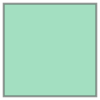

In [2]:
from shapely.geometry import box, polygon, multipolygon, Point
import shapely.geometry
from shapely.ops import linemerge, unary_union, transform
import shapely
from shapely.wkt import loads

from functools import partial
import pyproj
box = box(121.05, 14.6, 121.1, 14.65)
box

In [82]:
def clip_new(G, bound, source_crs = 'epsg:4326', target_crs = 'epsg:4326', geom_col = 'geometry'):
    """
    Removes any edges and nodes that fall beyond a polygon
    IMPORTANT: keeps all edges that are partially in/out of the polygon (differing from gn.clip)
    :param G: a graph object.
    :param bound: a shapely polygon object
    :param source_crs: crs object in format 'epsg:4326'
    :param target_crs: crs object in format 'epsg:4326'
    :param geom_col: label name for geometry object
    """

    edges_to_add, nodes_to_add = [],[]
    edges_to_remove, nodes_to_remove = [],[]

    if type(bound) == shapely.geometry.multipolygon.MultiPolygon or type(bound) == shapely.geometry.polygon.Polygon:
        pass
    else:
        raise ValueError('Bound input must be a Shapely Polygon or MultiPolygon object!')

    if type(G) != nx.classes.multidigraph.MultiDiGraph:
        raise ValueError('Graph object must be of type nx.classes.multidigraph.MultiDiGraph!')

    project_WGS_UTM = partial(
        pyproj.transform,
        pyproj.Proj(init=source_crs),
        pyproj.Proj(init=target_crs))

    G_copy = G.copy()
    print('pre_clip | nodes: %s | edges: %s' % (G_copy.number_of_nodes(), G_copy.number_of_edges()))

    existing_legitimate_point_geometries = {}
    for u, data in G_copy.nodes(data = True):
        geo_point = Point(round(data['x'],10),round(data['y'],10))
        if bound.contains(geo_point):
            existing_legitimate_point_geometries[u] = geo_point
        else:
            nodes_to_remove.append(u)

    iterator = 0
    done_edges = []

    for u, v, data in G_copy.edges(data = True):

        done_edges.append((v,u))

        if (u,v) in done_edges:
            pass

        else:
            # define basics from data dictionary
            infra_type = data['infra_type']
            #extract the geometry of the geom_col, if there is no explicit geometry, load the wkt
            try:
                geom = data[geom_col]
            except:
                geom = loads(data['Wkt'])

            # road fully within country - do nothing
            if bound.contains(geom) == True:
                pass

            # road fully outside country - remove entirely
            elif bound.intersects(geom) == False:

                edges_to_remove.append((u, v))
                edges_to_remove.append((v, u))
                nodes_to_remove.append(u)
                nodes_to_remove.append(v)

            # road partially in, partially out
            # ->leave in for simplicity

    # Remove bad geometries
    G_copy.remove_nodes_from(nodes_to_remove)
    G_copy.remove_edges_from(edges_to_remove)
   
    # Re-label nodes
    G_copy = nx.convert_node_labels_to_integers(G_copy)
    print('post_clip | nodes: %s | edges: %s' % (G_copy.number_of_nodes(), G_copy.number_of_edges()))
    return G_copy


In [88]:
def keep_largest_component(G):
    
    #takes a graph and returns only the largest strongly connected component of this graph
    # works with newer nx versions after nx.strongly_connected_component_subgraphs has been deprecated
    
    G_copy = G.copy()
    print('pre_removal | nodes: %s | edges: %s' % (G_copy.number_of_nodes(), G_copy.number_of_edges()))

    #remove isolated nodes 
    list_of_Gs = list((nx.strongly_connected_components(G_copy)))
    list_length = list(len(i) for i in list_of_Gs)
    m = max(list_length)
    index_of_max = [i for i, j in enumerate(list_length) if j == m][0]
    del(list_of_Gs)[index_of_max]
    isolated_nodes = []
    for isolated_comp in list_of_Gs:
        for isolated_node in isolated_comp:
            isolated_nodes.append(isolated_node)
    G_copy.remove_nodes_from(isolated_nodes)
    
    print('post_removal | nodes: %s | edges: %s' % (G_copy.number_of_nodes(), G_copy.number_of_edges()))

    return G_copy


In [84]:
G_clip = clip_new(G, box, source_crs = 'epsg:4326', 
                  target_crs = 'epsg:4326', geom_col = 'geometry', largest_G = True)

pre_clip | nodes: 89758 | edges: 247696
post_clip | nodes: 4107 | edges: 11407


In [85]:
G_clip = keep_largest_component(G_clip)

pre_removal | nodes: 4107 | edges: 11407
post_removal | nodes: 4075 | edges: 11367


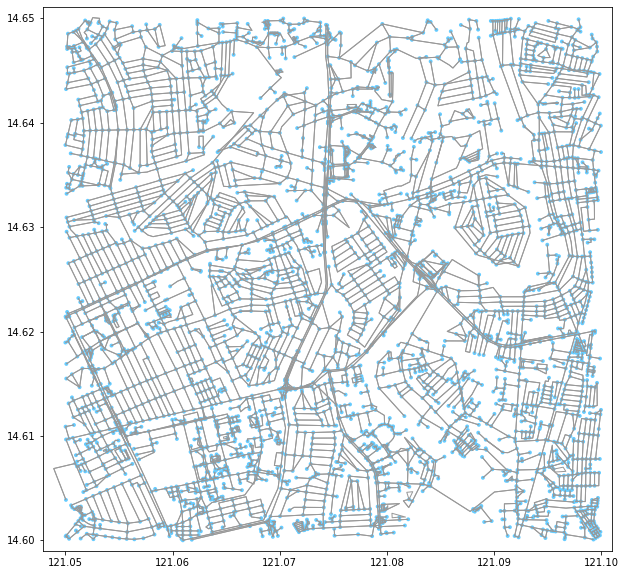

(<Figure size 734.362x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f08aa83f240>)

In [86]:
G_clip.graph.update( {'crs' : crs_global} )
G_clip.graph.update( {'name' : 'manila'} )
ox.plot_graph(G_clip, fig_height=10, axis_off=False)

In [88]:
gn.save(G_clip,'manila_clean_clipped','data_osm_raw')

## import hazard data and plot, check

In [142]:
import geopandas as gpd
import pandas as pd
import GOSTnets as gn
import networkx as nx
import osmnx as ox

In [143]:
#https://epsg.io/3123
crs_manila = {'init': 'epsg:3123'}
crs_global = {'init': 'epsg:4326'}

In [144]:
cd /home/op/network_manila

/home/op/network_manila


In [145]:
#import hazard data

liquefaction = gpd.read_file(r"hazard_data/Liquefaction/Liquefaction_MetroManila.shp")
faultline = gpd.read_file(r"hazard_data/ActiveFault/ActiveFault_MetroManila.shp")

In [148]:
liquefaction.crs, faultline.crs

({'init': 'epsg:4326'}, {'init': 'epsg:4326'})

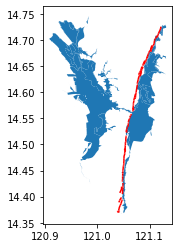

In [146]:
base=liquefaction.plot()
faultline.plot(ax=base, color='red')

In [147]:
#buffer around faultline (50 meters)

faultline["geometry_buffer50"] = faultline.geometry
faultline = faultline.set_geometry("geometry_buffer50")
faultline = faultline.to_crs(crs_manila)
faultline["geometry_buffer50"] = faultline.geometry.buffer(50)
faultline = faultline.to_crs(crs_global)


In [149]:
#import asset data

schools = gpd.read_file(r"asset_data/MetroManila/MetroManila/DepEd/SchoolLocation.shp")
hospitals = gpd.read_file(r"asset_data/MetroManila/MetroManila/DOH/HealthFacilities.shp")

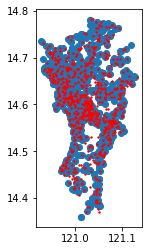

In [150]:
base=schools.plot()
hospitals.plot(ax=base, color='red', markersize=2)

In [160]:
len(schools), len(hospitals), schools.crs, hospitals.crs

(768, 734, {'init': 'epsg:4326'}, {'init': 'epsg:4326'})

In [155]:
G.graph.update( {'crs' : crs_global} )
G.graph.update( {'name' : 'manila'} )

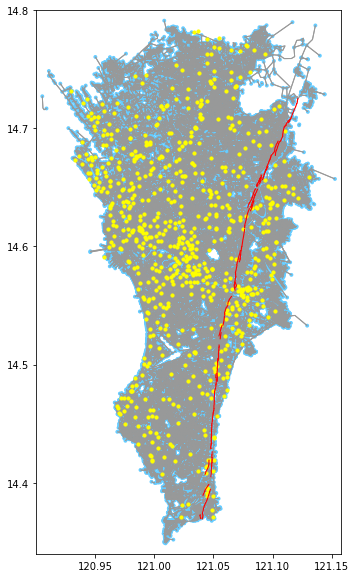

<Figure size 432x288 with 0 Axes>

In [164]:
fig, ax = ox.plot_graph(G, fig_height=10, axis_off=False, show=False)
faultline.plot(ax=ax, color='red', zorder=3)
hospitals.plot(ax=ax, color='yellow', markersize=10, zorder=2)
fig

## disrupt network with hazard data

In [9]:
import shapely
from shapely.wkt import loads
from shapely.geometry import LineString, MultiLineString, Point


In [157]:
def tag_nodes_intersecting_gdf(G, gdf, property_name = 'intersects_gdf'):
    """
    this function tags each node of the graph which lies within the passed geodataframe's polygon
    note that graph and gdf must be in the same crs!
    :param G: a graph containing one or more nodes
    :param gdf: a geodataframe
    :param property_name: a property name for whether the node intersects the gdf
    :returns: a graph
    """

    G_copy = G.copy()
    
    if type(G_copy) == nx.classes.multidigraph.MultiDiGraph or type(G_copy) == nx.classes.digraph.DiGraph:
        pass
    else:
        raise ValueError('Expecting a graph or geodataframe for G!')

    # generate dictionary of {node ID: point} pairs
    try:
        list_of_nodes = {}
        for u, data in G_copy.nodes(data=True):
            list_of_nodes.update({u:(data['x'], data['y'])})
    except:
        raise ValueError('loading point geometry went wrong. Ensure node data dict includes x, y values!')

    # get gdf geometry
    try:
        gdf_geometry = gdf.unary_union
    except:
        raise ValueError('Expecting a geodataframe!')

    # create list of values, throw out nodes that don't intersect the gdf
    selKeys = []
    selPts = []
    for key, pt in list_of_nodes.items():
        if Point(pt[0], pt[1]).intersects(gdf_geometry):
            selPts.append(1)
            selKeys.append(key)

    # generate new dictionary of {node ID: 1 where 1 signals intersection}
    ref = dict(zip(selKeys, selPts))

    # load new values onto node data dictionary, set to 0 if not intersecting
    missedCnt = 0
    for u, data in G_copy.nodes(data=True):
        try:
            data[property_name] = ref[u]
        except:
            data[property_name] = 0
            missedCnt += 1
    print("Number of original nodes:", len(G_copy.nodes))
    print("Number of missed nodes gdf:", missedCnt)
    print("Number of nodes that intersect gdf:", len(selKeys))

    return G_copy

In [158]:
G_liq = tag_nodes_intersecting_gdf(G_clip, liquefaction, property_name = 'intersects_liquefaction')

Number of original nodes: 4075
Number of missed nodes gdf: 2557
Number of nodes that intersect gdf: 1518


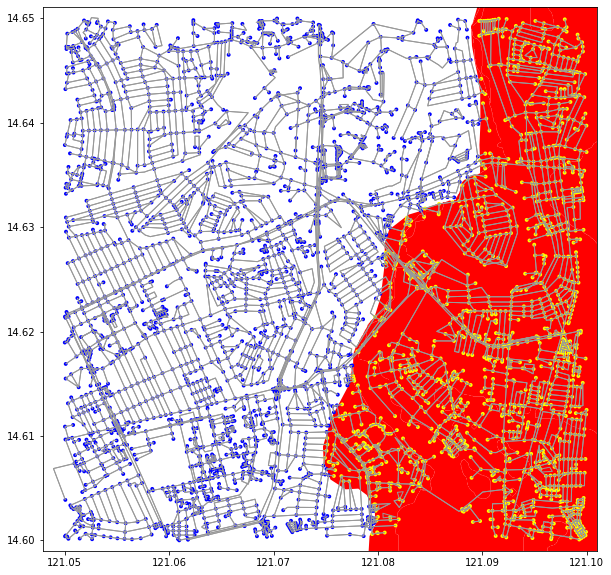

<Figure size 432x288 with 0 Axes>

In [159]:
G_liq.graph.update( {'crs' : crs_global} )
G_liq.graph.update( {'name' : 'manila'} )
nc = ['yellow' if data['intersects_liquefaction']==1 else 'blue' for u, data in G_liq.nodes(data=True)]
fig, ax = ox.plot_graph(G_liq, fig_height=10, axis_off=False, show=False, node_color=nc)
liquefaction.plot(ax=ax, color='red', zorder=0)
fig

In [107]:
def remove_edges_intersecting_polygons(G, polygons, mode,crs = None, fast = False):
    """
    Function for removing edges of a graph that intersect polygon(s).
    Ensure any GeoDataFrames are in the same projection before using function, or pass a crs.
    Wrapper function around gn.grah_edges_intersecting_polygons


    :param G: a Graph object
    :param polygons: a GeoDataFrame containing one or more polygons
    :param mode: a string, either 'contains' or 'intersects'
    :param crs: If passed, will reproject both polygons and graph edge gdf to this projection.
    :param fast: (default: True): we can cheaply test whether an edge intersects a polygon gdf by checking whether either the start or end nodes are within a polygon. If both are, then we return 'contained'; if at least one is, we can return 'intersects'. If we set fast to False, then we iterate through each geometry one at a time, and check to see whether the geometry object literally intersects the polygon geodataframe, one at a time. May be computationally intensive!
    :returns: the graph with edges intersecting polygons as well as isolated nodes removed
    """
    
    G_copy = G.copy()
    
    #identify and remove nodes intersecting polygons
    nodes_gdf = gn.graph_edges_intersecting_polygon(G_clip, polygons = polygons, mode = mode,
                                               crs = crs, fast = fast) 
    edges_to_remove = list(zip(nodes_gdf_faultline['stnode'], nodes_gdf_faultline['endnode']))
    G_copy.remove_edges_from(edges_to_remove)

    
    #remove isolated nodes that are no longer connected to any edges
    outdeg = G_copy.out_degree()
    nodes_to_remove = [n for (n, deg) in outdeg if deg == 0]
    G_copy.remove_nodes_from(nodes_to_remove)
    
    return G_copy


In [108]:
G_faultline = remove_edges_intersecting_polygons(G_clip, polygons = faultline, mode = "intersects",
                                               crs = None, fast = False)

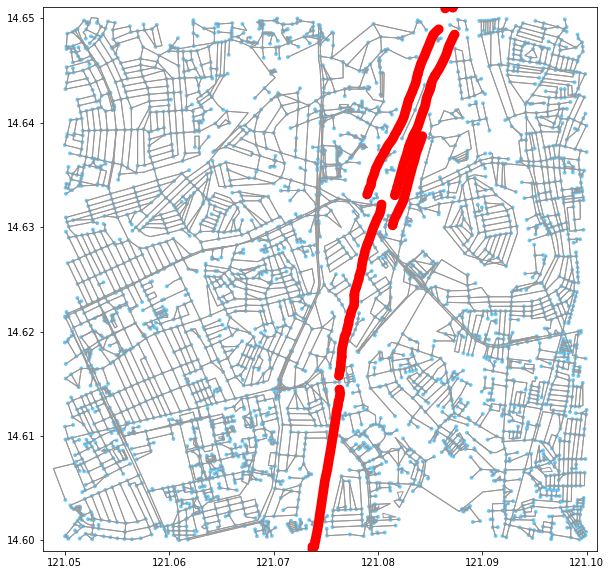

<Figure size 432x288 with 0 Axes>

In [128]:
fig, ax = ox.plot_graph(G_faultline, fig_height=10, axis_off=False, show=False)
faultline.plot(ax=ax, color='red')
fig

disruption in GN is working based on whether nodes are in field of disaster -
this is bad if long edges without nodes lead through disaster fields, as these will not be affected. 
one solution to this is the salt long lines option


for ground liquefaction we want to slow everything down - could use approach similar to this: 
    https://github.com/worldbank/GOST_PublicGoods/blob/master/Implementations/SierraLeone%20-%20GOSTnets/Step%204.a%20-%20Generate%20Flooding%20Version%20of%20Graph.ipynb

In [ ]:

def disrupt_network(G, property, thresh, fail_value):
    """
    Function for disrupting a graph given a threshold value against a node's value. 
    Any edges which bind to broken nodes have their 'time' property set to fail_value


## od matrices

In [ ]:
project graph
convert to time

In [39]:
gn.example_node(G)

(0, {'x': 121.032836, 'y': 14.566063})


In [40]:
gn.example_edge(G)

(0, 19650, {'Wkt': 'LINESTRING (121.032836 14.566063, 121.033509 14.5655514)', 'id': 18962, 'infra_type': 'residential', 'osm_id': '23006710', 'key': 'edge_18962', 'length': 0.0920008330049905, 'Type': 'legitimate'})


In [ ]:
disruptio

gn bugs

- function graph_edges_intersecting_polygon(G, polygons, mode, crs = None, fast = True) specifies moode= 'intersecting' as param, but checks for 'intersects'

- function clip doesn't work because shapely isn't imported 
- function clip doesn't work with new networkx